# Cumulative flow

Surface flow algorithms rely on the interconnection of nodes to pass information from one node to another in a downhill direction. Some algorithms include multiple downhill pathways where information is passed from a parent node to more than one downhill neighbours. Flow is split among $N$ downhill neighbours using

$$
\frac{Q_i}{Q_{\mathrm{total}}} = \frac{S_i^\alpha}{\sum_{i=1}^{N} S_i^{\alpha}}
$$

where $Q_{\mathrm{total}}$ is the total water discharge flowing through the node, $Q_i$ is the discharge into the immediate downstream node, $S$ is the local slope, $i$, and $\alpha$ is a partitioning parameter (usually $\alpha=\frac{1}{2}$). This notebook explores the propagation of information to downstream areas using one or two pathways.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import clock
%matplotlib inline

from quagmire import SurfaceProcessMesh # all routines we need are within this class
from quagmire import TopoMesh # all routines we need are within this class
from quagmire import tools as meshtools

In [2]:
# Construct a mesh
minX, maxX = -5.0, 5.0
minY, maxY = -5.0, 5.0

x1, y1, bmask1, = meshtools.elliptical_mesh(minX, maxX, minY, maxY, 0.05, 0.05, samples=200000, boundary_samples=2000)

i = np.random.permutation(len(x1))

x = x1[i]
y = y1[i]
bmask = bmask1[i]



Origin =  0.0 0.0 Radius =  5.0 Aspect =  1.0


In [3]:
radius  = np.sqrt((x**2 + y**2))
theta   = np.arctan2(y,x)
# height  = np.exp(-0.01 *(x**2 + y**2)**2) + 0.25 * (0.2*radius)**8  * np.cos(30.0*theta)**2 ## Concentrated
height  = np.exp(-0.025*(x**2 + y**2)**2) 
height  += 0.25 * (0.2*radius)**4  * np.cos(5.0*theta)**2 ## Less so
height  -= 0.25 * (0.2*radius)**8  * np.sin(10.0*theta)**2 ## Less so
height  += 0.1 * (1.0-0.2*radius)

# height  += 0.05 * np.random.random(height.shape)

print height.max(), height.min()

1.0999053471 -0.142231085087


In [4]:
dm = meshtools.create_DMPlex_from_points(x, y, bmask)

mesh = SurfaceProcessMesh(dm)
mesh.update_height(height)


 - Delaunay triangulation 0.500504s
 - cKDTree 0.063864s
 - Calculate node weights and area 2.475636s
 - Compute edge lengths 0.330778s
 - Construct nearest neighbour array 1.176823s
 - Find boundaries 0.042786s
 - Build smoothing matrix 0.080906s
 - Construct neighbour cloud array 0.779369s
 - Construct rbf weights 0.257508s
 - Sort nodes by field 0.381411s
 - Build downhill matrices 0.591392s


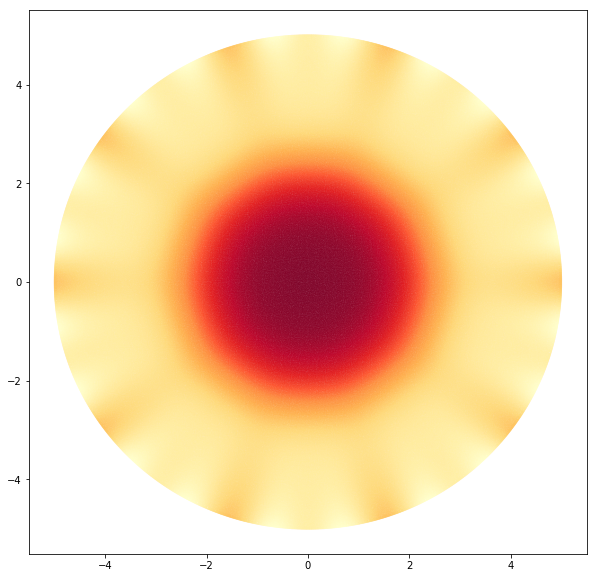

In [5]:
fig, (ax1) = plt.subplots(1,1, figsize=(10,10))
ax1.tripcolor(x, y, mesh.tri.simplices, height, cmap='YlOrRd', 
              shading='gouraud', alpha=0.5, zorder=1)

fig.savefig("CrenulatedSombrero.png", dpi=200)

## One, two or three downhill neighbours

We can build different variants of the downhill propagation matrix including different numbers of downhill neighbours -- one, two (the default) or all.

 1. The `downhillMat` matrix houses the downstream neighbour network. It is the (weighted) sum of two matrices `adjacency1` and `adjacency2` which contain the first and second neighbours respectively. Below we replace `downhillMat` with `adjacency1`.
 
 2. This is the default setting in Quagmire. It uses the partitioning algorithm above to split information among downhill neighbours. If there is only one downhill neighbour then all the flow is directed to that node.

 3. Now we split flow into all downhill neighbours. There may be several recipient nodes that are lower than the parent node depending on the unstructured mesh.
 
The test surface is a smooth hill that runs down into a corrugated plain. A uniform runoff pattern should fill each of the channels at the outflow position equally. 

In [6]:
down1 = mesh.adjacency1.copy()
mesh.downhillMat = down1
down1T = down1.copy().transpose()

print "No of local minima = ", np.count_nonzero(down1T.getRowSum().array == 0.0)


No of local minima =  20


In [7]:
mesh._build_downhill_matrix_new()
down2 = mesh.downhillMat.copy()

In [8]:
down3 = mesh.downhillMat3.copy()

In [9]:
def downhill_propagation(mesh, downhillMat, vector):
    """ time the propagation of information downhill """
    
    mesh.downhillMat = downhillMat
    t = clock()
    cumvec = mesh.cumulative_flow(vector)
    return cumvec, clock() - t

upstream_area_1n, t_1n = downhill_propagation(mesh, down1, mesh.area)
upstream_area_2n, t_2n = downhill_propagation(mesh, down2, mesh.area)
upstream_area_3n, t_3n = downhill_propagation(mesh, down3, mesh.area)

## Comparison plot

Max Area 1,2,3:  5.72139294581 4.29657746881 4.16332494954


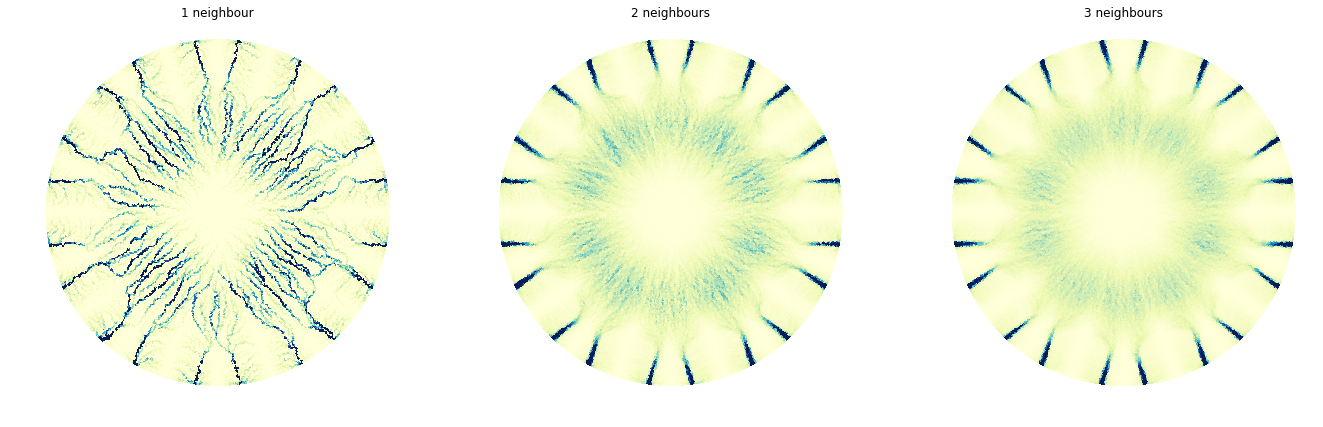

In [10]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(23,7))
for ax in [ax1,ax2,ax3]:
    ax.axis('off')

vmax = np.mean([upstream_area_1n.max(), upstream_area_2n.max(), upstream_area_3n.max()])
print "Max Area 1,2,3: ", upstream_area_1n.max(), upstream_area_2n.max(), upstream_area_3n.max()

vmax=0.1

im1 = ax1.tripcolor(x, y, mesh.tri.simplices, upstream_area_1n*mesh.slope, cmap='YlGnBu', vmax=vmax)
im2 = ax2.tripcolor(x, y, mesh.tri.simplices, upstream_area_2n*mesh.slope, cmap='YlGnBu', vmax=vmax)
im3 = ax3.tripcolor(x, y, mesh.tri.simplices, upstream_area_3n*mesh.slope, cmap='YlGnBu', vmax=vmax)

ax1.set_title('1 neighbour')
ax2.set_title('2 neighbours')
ax3.set_title('3 neighbours')

fig.savefig("OctopusUnderpants-Downhill-123-flows.png", dpi=150)

plt.show()


In [27]:
rain = np.ones_like(mesh.height)
rain[np.where(mesh.height<0.98)]=0.0
mesh.update_surface_processes(rainfall_pattern=rain, sediment_distribution=np.zeros_like(rain))

rainfall          = mesh.area * rain 
cumulative_runoff = mesh.cumulative_flow(rainfall, use3path=True)
stream_power = cumulative_runoff * mesh.slope

mesh._construct_rbf_weights(delta=mesh.neighbour_cloud_distances[:,1].mean()*2.0)
smooth_sp = mesh.rbf_smoother(stream_power)

down = mesh.downhillMat
mesh.downhillMat = mesh.adjacency1
stream_power1 = mesh.cumulative_flow(rainfall) * mesh.slope


 - Upstream area 0.491009s


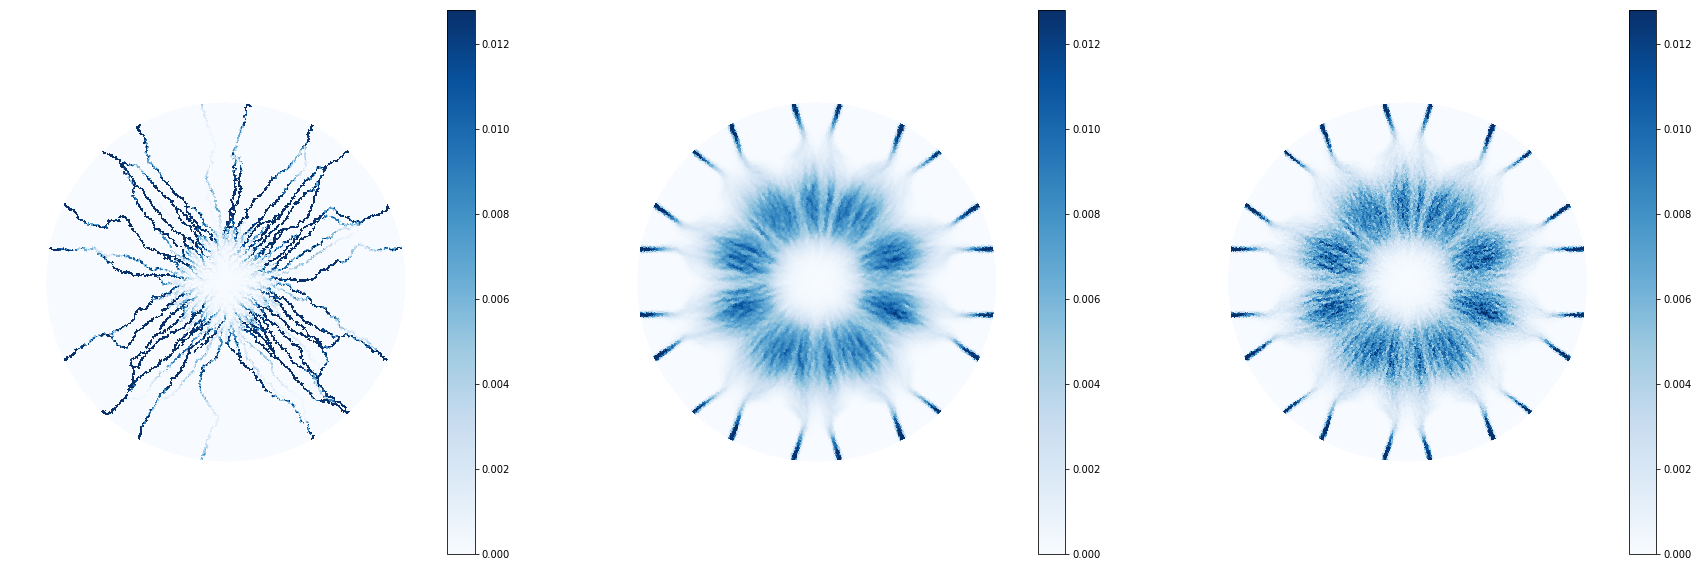

In [28]:
# Plot the height, rainfall, and stream power
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,10))
for ax in [ax1, ax2, ax3]:
    ax.axis('equal')
    ax.axis('off')
    
im1 = ax1.tripcolor(x, y, mesh.tri.simplices, stream_power1, cmap='Blues', vmax=stream_power.mean()*5.0)
im2 = ax2.tripcolor(x, y, mesh.tri.simplices, smooth_sp, cmap='Blues', vmax=stream_power.mean()*5.0)
im3 = ax3.tripcolor(x, y, mesh.tri.simplices, stream_power, cmap='Blues', vmax=stream_power.mean()*5.0)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
plt.show()

# Analysis

The topography function has an exact 20 fold rotational symmetry. Variations in the cumulative area (or rainfall) to the outflow points is numerical noise associated with meshing / path selection. 




# of outflow points  20


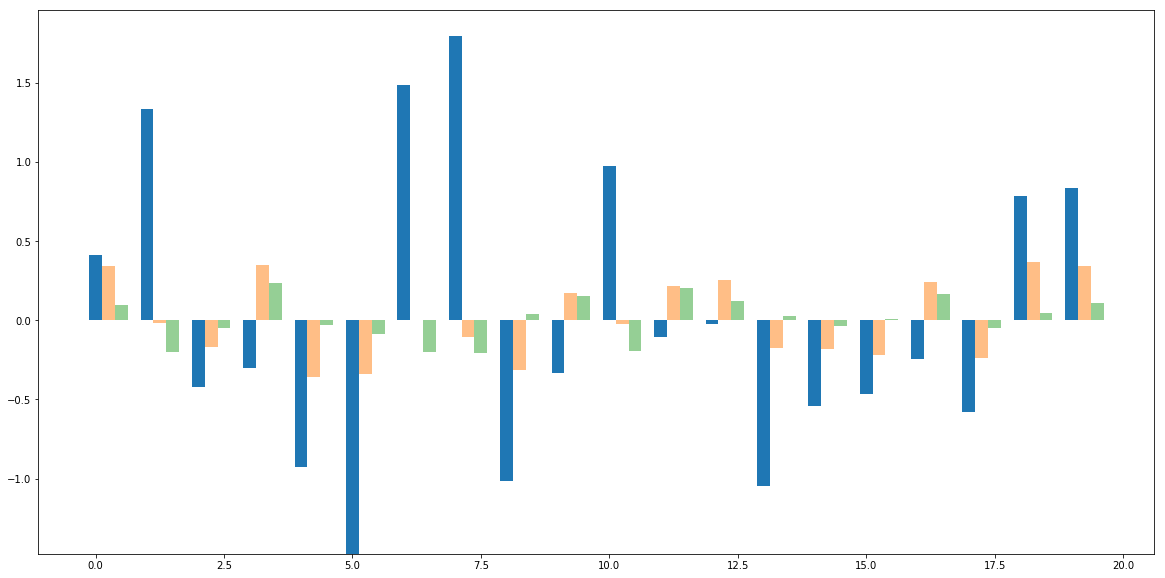

In [30]:
outflow_points = mesh.identify_outflow_points()

print "# of outflow points ", len(outflow_points)

bar_width=0.25

uniform_value = (np.pi*5.0**2)/ len(outflow_points)

fig, (ax1) = plt.subplots(1,1, figsize=(20,10))

ax1.bar( left=range(0,len(outflow_points)), 
        height=upstream_area_1n[outflow_points]-uniform_value, width=bar_width)

ax1.bar( left=np.arange(0,len(outflow_points))+bar_width, 
         height=upstream_area_2n[outflow_points]-uniform_value, width=bar_width, alpha=0.5)

ax1.bar( left=np.arange(0,len(outflow_points))+2.0*bar_width, 
         height=upstream_area_3n[outflow_points]-uniform_value, width=bar_width, alpha=0.5)


fig.savefig("OutflowHistogram-OctoPants.png", dpi=200)




In [31]:
def catchment_analysis(mesh, downhillMat, catchmentList=None):
    
    outflow_pts = mesh.identify_outflow_points()
    
    if catchmentList == None:
        catchmentList = range(0,len(outflow_points),1)
    
    oldDMat = mesh.downhillMat
    dhMat2 = downhillMat.copy().transpose()   
    mesh.downhillMat = dhMat2

    catchments=[]
    catchmentweight=[]

    ## This might seem unnecessary, but it ensure the same 
    ## Ordering for the catchments and the same colours in the plots
    for n in catchmentList:
        for i, outflow_pt in enumerate(outflow_points):
            if i == n: 
                vector = np.zeros_like(mesh.height)
                vector[outflow_pt] = 1.0
                catch = mesh.cumulative_flow(vector)
                catchpts = np.where(catch > 0.0)[0]
                catch2 = catch[catchpts]
                catchments.append(catchpts)
                catchmentweight.append(catch2)

               
    mesh.downhillMat = oldDMat
    return catchments, catchmentweight
  

In [32]:
catchments1, catchmentw1 = catchment_analysis(mesh, down1)
catchments2, catchmentw2 = catchment_analysis(mesh, down2)
catchments3, catchmentw3 = catchment_analysis(mesh, down3)

In [33]:
colors = np.array(  [[0.0,0.0,1.0],  # Blue
                     [0.0,1.0,0.0],  # Green
                     [1.0,0.5,0.0],  # Orange
                     [1.0,0.0,0.0],  # Red
                     [0.5,0.5,0.5]] )


catchments = len(mesh.identify_outflow_points())
sortOrder  = np.argsort(np.arctan2(y[outflow_points],x[outflow_points]))
colorID = np.zeros(catchments, dtype=np.int)

for i in range(0,catchments):
    colorID[sortOrder[i]] = i%5

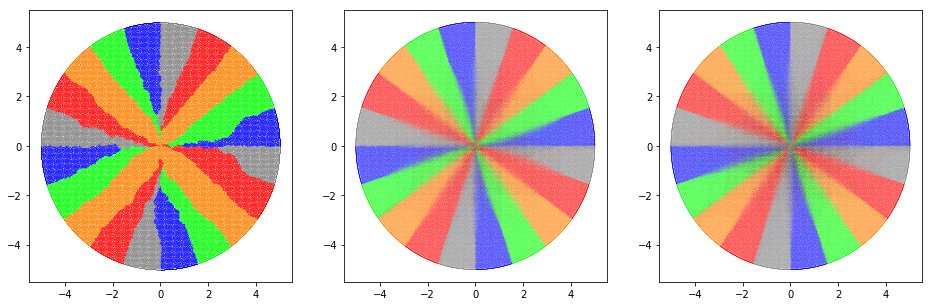

In [34]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(16,5))
ax1.set_xlim(-5.5,5.5)
ax1.set_ylim(-5.5,5.5)

ax2.set_xlim(-5.5,5.5)
ax2.set_ylim(-5.5,5.5)

ax3.set_xlim(-5.5,5.5)
ax3.set_ylim(-5.5,5.5)


for cid in range(0, catchments):
    cid0 = colorID[cid]
    
    #1 
    ax1.scatter(x[catchments1[cid]], y[catchments1[cid]], c=colors[cid0],  
                   alpha=0.5, zorder=1, s=0.5, linewidth=0.0)
       
    #2 
    ax2.scatter(x[catchments2[cid]], y[catchments2[cid]], c=colors[cid0],  
                   alpha=1.0, zorder=1, s=catchmentw2[cid] * 0.3+0.01, linewidth=0.0)
       
    #3       
    ax3.scatter(x[catchments3[cid]], y[catchments3[cid]], c=colors[cid0],  
                   alpha=1.0, zorder=1, s=catchmentw3[cid] * 0.3+0.01, linewidth=0.0)
    


fig.savefig("OctopusUnderpants-Downhill-123-catchments.png", dpi=300)

In [35]:
catchmentList = sortOrder[::4]

catchments1_5, catchmentw1_5 = catchment_analysis(mesh, down1, catchmentList=catchmentList)
catchments2_5, catchmentw2_5 = catchment_analysis(mesh, down2, catchmentList=catchmentList)
catchments3_5, catchmentw3_5 = catchment_analysis(mesh, down3, catchmentList=catchmentList)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


0  catchment  4  color  0
1  catchment  13  color  4
2  catchment  19  color  3
3  catchment  10  color  2
4  catchment  16  color  1


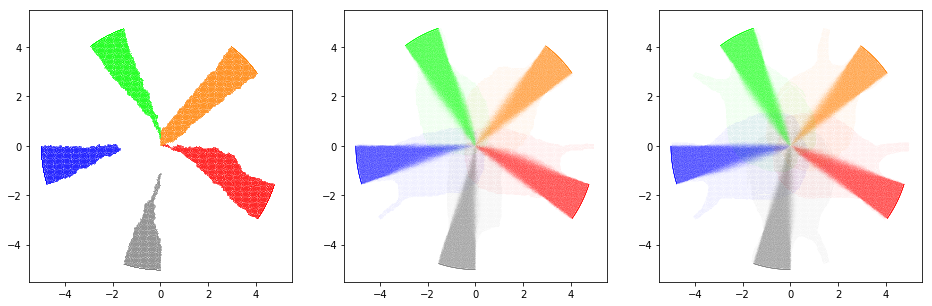

In [36]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(16,5))
ax1.set_xlim(-5.5,5.5)
ax1.set_ylim(-5.5,5.5)

ax2.set_xlim(-5.5,5.5)
ax2.set_ylim(-5.5,5.5)

ax3.set_xlim(-5.5,5.5)
ax3.set_ylim(-5.5,5.5)


for cid in range(0, len(catchmentList), 1): 
    cid0 = colorID[catchmentList[cid]]
    print  cid," catchment ", catchmentList[cid], " color ", cid0

    #1 
    ax1.scatter(x[catchments1_5[cid]], y[catchments1_5[cid]], c=colors[cid0],  
                   alpha=0.5, zorder=1, s=0.5, linewidth=0.0)
       
    #2 
    ax2.scatter(x[catchments2_5[cid]], y[catchments2_5[cid]], c=colors[cid0],  
                   alpha=1.0, zorder=1, s=catchmentw2_5[cid] * 0.3+0.02, linewidth=0.0)
       
    #3       
    ax3.scatter(x[catchments3_5[cid]], y[catchments3_5[cid]], c=colors[cid0],  
                   alpha=1.0, zorder=1, s=catchmentw3_5[cid] * 0.3+0.02, linewidth=0.0)
    
      
fig.savefig("OctopusUnderpants-Downhill-123-catchments12345.png") 

## Movie: One downhill neighbour

## Movie: Two downhill neighbours


## Movie 3 downhill neighbours


## Compare upstream area

Examine the difference in upstream area for the three neighbour combinations.

$$
A_{\mathrm{upstream}} = \int_{\mathrm{upstream}} \!\!\!\! A(\xi) \, \mathrm{d}\xi
$$

## Timings

The number of iterations to propogate information out of the domain increases with the number of downhill neighbours. One downhill neighbour is the fastest, yet the least realistic. Two downhill neighbours offers a good compromise between realistic flow and computation time.

In [ ]:
def timed_downhill_propagation(downhillMat, vector):
    """ time the propagation of information downhill """
    mesh.gvec.setArray(vector)
    DX0 = mesh.gvec.copy()
    DX1 = mesh.gvec.copy()

    DX1_sum = DX1.sum()
    tt = [0.]
    ua = [DX1_sum]
    
    step = 0
    DX1_sum0 = DX1_sum
    
    t = clock()

    while DX1_sum > 1e-8 * DX1_sum0:
        
        DX1 = downhillMat*DX1
        DX0 += DX1
        DX1_sum = DX1.sum()
        
        tt.append(clock() - t)
        ua.append(DX1_sum)
        step += 1

        # print DX1_sum, DX1_sum0, step
        
    return ua, tt

ua_1n, tt_1n = timed_downhill_propagation(down1, mesh.area)
ua_2n, tt_2n = timed_downhill_propagation(down2, mesh.area)
ua_Nn, tt_Nn = timed_downhill_propagation(down3, mesh.area)

In [ ]:
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax1.plot(tt_1n, (ua_1n), label='1 neighbour')
ax1.plot(tt_2n, (ua_2n), label='2 neighbours')
ax1.plot(tt_Nn, (ua_Nn), label='$N$ neighbours')
plt.legend()
plt.show()

## Changing path length without changing the mesh

An interesting comparison of the different downhill transport algorithms is to keep the mesh fixed but have arbitrarily longer paths ... we can do this with the magical spiral mountain

In [ ]:
radius         = np.sqrt((x**2 + y**2))
theta          = np.arctan2(y,x)
spiral_factor  = 2.5
height  = 0.5 * np.cos(2.0*theta+spiral_factor*radius)**2 
height  += 1.0 * (1.0-0.2*radius)


print height.max(), height.min()

In [ ]:
mesh.update_height(height)

print "No of low points - ", len(mesh.identify_low_points())

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(10,10))
ax1.tripcolor(x, y, mesh.tri.simplices, height, cmap='YlOrRd', 
              shading='gouraud', alpha=0.5, zorder=1)

fig.savefig("OutflowHistogram-SpiralSom.png", dpi=200)


In [ ]:

down1 = mesh.adjacency1.copy()
down2 = mesh.downhillMat.copy()
down3 = mesh.downhillMat3.copy()

upstream_area_1n, t_1n = downhill_propagation(mesh, down1, mesh.area)
upstream_area_2n, t_2n = downhill_propagation(mesh, down2, mesh.area)
upstream_area_3n, t_Nn = downhill_propagation(mesh, down3, mesh.area)

In [ ]:
outflow_points = mesh.identify_outflow_points()
low_points = mesh.identify_low_points()

print "1n - ", upstream_area_1n[outflow_points].sum()
print "2n - ", upstream_area_2n[outflow_points].sum()
print "3n - ", upstream_area_3n[outflow_points].sum()

print "1n - ", upstream_area_1n[low_points].sum()
print "2n - ", upstream_area_2n[low_points].sum()
print "3n - ", upstream_area_3n[low_points].sum()

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(21,7))
for ax in [ax1,ax2,ax3]:
    ax.axis('off')

vmax = 0.25 * np.mean([upstream_area_1n.max(), upstream_area_2n.max(), upstream_area_3n.max()])
print "Max Area 1,2,N: ", upstream_area_1n.max(), upstream_area_2n.max(), upstream_area_3n.max()

im1 = ax1.tripcolor(x, y, mesh.tri.simplices, upstream_area_1n, cmap='YlGnBu', vmax=vmax)
im2 = ax2.tripcolor(x, y, mesh.tri.simplices, upstream_area_2n, cmap='YlGnBu', vmax=vmax)
im3 = ax3.tripcolor(x, y, mesh.tri.simplices, upstream_area_3n, cmap='YlGnBu', vmax=vmax)

ax1.set_title('1 neighbour')
ax2.set_title('2 neighbours')
ax3.set_title('3 neighbours')

fig.savefig("SpiralSombrero-Downhill-123-flows.png", dpi=150)



plt.show()

In [ ]:
ua_1n, tt_1n = timed_downhill_propagation(down1, mesh.area)
ua_2n, tt_2n = timed_downhill_propagation(down2, mesh.area)
ua_3n, tt_3n = timed_downhill_propagation(down3, mesh.area)

fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax1.plot(tt_1n, (ua_1n), label='1 neighbour')
ax1.plot(tt_2n, (ua_2n), label='2 neighbours')
ax1.plot(tt_3n, (ua_3n), label='3 neighbours')
plt.legend()
plt.show()

In [ ]:
down1T = down1.copy().transpose()
low_points =  np.where(down1T.getRowSum().array == 0.0)[0]

print "number of low points", low_points.shape[0]

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(21,21))

im1 = ax1.tripcolor(x, y, mesh.tri.simplices, upstream_area_1n, cmap='YlGnBu', vmax=vmax)
# im2 = ax2.tripcolor(x, y, mesh.tri.simplices, upstream_area_2n, cmap='YlGnBu', vmax=vmax)
# im3 = ax3.tripcolor(x, y, mesh.tri.simplices, upstream_area_Nn, cmap='YlGnBu', vmax=vmax)

# ax1.tripcolor(x, y, mesh.tri.simplices, height, cmap='YlOrRd', 
#               shading='gouraud', alpha=0.5, zorder=1)

# ax1.scatter(x, y, s=1, marker=".")
ax1.scatter(x[low_points], y[low_points], s=250.0, marker="x")


In [ ]:
catchments1s, catchmentw1s = catchment_analysis(mesh, down1)
catchments2s, catchmentw2s = catchment_analysis(mesh, down2)
catchments3s, catchmentw3s = catchment_analysis(mesh, down3)

In [ ]:
catchments = len(mesh.identify_outflow_points())

cmaps = ["Blues", "Greys", "Greens", "Oranges", "Reds"]
colors = np.array(  [[0.0,0.0,1.0],
                     [0.0,1.0,0.0],
                     [1.0,0.5,0.0],
                     [1.0,0.0,0.0],
                     [0.5,0.5,0.5]] )


fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(16,5))
ax1.set_xlim(-5.5,5.5)
ax1.set_ylim(-5.5,5.5)

ax2.set_xlim(-5.5,5.5)
ax2.set_ylim(-5.5,5.5)

ax3.set_xlim(-5.5,5.5)
ax3.set_ylim(-5.5,5.5)


for cid in range(0, catchments, 1):

    #1 
    ax1.scatter(x[catchments1s[cid]], y[catchments1s[cid]], c=colors[cid%5],  
                   alpha=0.5, zorder=1, s=0.5, linewidth=0.0)
       
    #2 
    ax2.scatter(x[catchments2s[cid]], y[catchments2s[cid]], c=colors[cid%5],  
                   alpha=1.0, zorder=1, s=catchmentw2s[cid] * 0.3+0.01, linewidth=0.0)
       
    #3       
    ax3.scatter(x[catchments3s[cid]], y[catchments3s[cid]], c=colors[cid%5],  
                   alpha=1.0, zorder=1, s=catchmentw3s[cid] * 0.3+0.01, linewidth=0.0)
    


fig.savefig("SpiralSombrero-Downhill-123-catchments.png", dpi=300)